In [1]:
using CSV
using DataFrames
using Plots
using Statistics

In [2]:
include("./src/utils.jl");

In [107]:
scenario = 11
year = 1998
gen_prop_name = "vivienne_2050"
bus_prop_name = "vivienne_2050"
branch_prop_name = "vivienne_2050"

# Define constants
batt_duration = 8
storage_eff = 0.85 # Efficiency for general storage
gilboa_eff = 0.75 # Efficiency for specific storage (e.g., Gilboa)
nt = 8760

n_if_lims = 15

# Set flags
newHVDC = true
HydroCon = true
tranRating = true
networkcon = true

# Read grid data
gen_prop = CSV.read("$(data_dir)/grid/gen_prop_$(gen_prop_name).csv", DataFrame, header=true, stringtype=String)
bus_prop = CSV.read("$(data_dir)/grid/bus_prop_$(bus_prop_name).csv", DataFrame, header=true, stringtype=String)
branch_prop = CSV.read("$(data_dir)/grid/branch_prop_$(branch_prop_name).csv", DataFrame, header=true, stringtype=String)

bus_ids = bus_prop[:, 1]

# Get scaling factors
cc_scenario, bd_rate, ev_rate, wind_scalar, solar_scalar, batt_scalar = read_scaling_factors(scenario)

############## Load ####################
load = get_load(cc_scenario, year, ev_rate, bd_rate, bus_ids)
load = subtract_small_hydro(load, bus_ids)
load = subtract_solar_dpv(load, bus_ids, cc_scenario, year, solar_scalar)

############## Supply ##############
# Read hydro
niagra_hydro, moses_saund_hydro = get_hydro(cc_scenario, year)

# Add utility solar generators
solar_upv_gen, solar_upv_bus_ids = get_solar_upv(cc_scenario, year, solar_scalar)
gen_prop = add_upv_generators(gen_prop, solar_upv_bus_ids)

# Add wind generators to the model
wind_gen, wind_bus_ids = get_wind(year, wind_scalar)
gen_prop = add_wind_generators(gen_prop, wind_bus_ids)

# HVDC generators
gen_prop = add_hvdc(gen_prop)

# Get generator limits
g_max = repeat(gen_prop[:, "PMAX"], 1, nt) # Maximum real power output (MW)
g_min = repeat(gen_prop[:, "PMIN"], 1, nt) # Minimum real power output (MW)

# Update for renewables
wind_idx = findall(x -> x == "Wind", gen_prop[:, "UNIT_TYPE"])
g_max[wind_idx, :] = wind_gen[:, 1:nt]

solar_upv_idx = findall(x -> x == "SolarUPV", gen_prop[:, "UNIT_TYPE"])
g_max[solar_upv_idx, :] = solar_upv_gen[:, 1:nt]

# Get generator ramp rates
ramp_down = max.(repeat(gen_prop[:, "RAMP_30"], 1, nt) .* 2, repeat(gen_prop[:, "PMAX"], 1, nt)) # max of RAMP_30, PMAX??
ramp_up = copy(ramp_down)

# Note in the original model there is cost info: skipping for now
# since it's not used in the 2040 analysis

############## Grid ##############
# Transmission interface limits
if_lim_up, if_lim_dn, if_lim_map = get_if_lims(year, n_if_lims)

# Branch limits
branch_lims = repeat(Float64.(branch_prop[:, "RATE_A"]), 1, nt)
branch_lims[branch_lims.==0] .= 99999.0

# Storage
charge_cap, storage_cap, storage_bus_ids = get_storage(batt_scalar, batt_duration)

########## Optimization ##############
n_gen = size(gen_prop, 1)
n_bus = size(bus_prop, 1)
n_branch = size(branch_prop, 1);

In [34]:
# My results
scenario = 11
year = 1998
julia_path = "./out/Scenario$(scenario)";

# Vivienne's results
vivienne_results_path = "/Users/dcl257/Projects/current_projects/nys_comparison/data_vivienne_hopper/SimulationResults"
orig_path = "$(vivienne_results_path)/Scenario$(scenario)/";

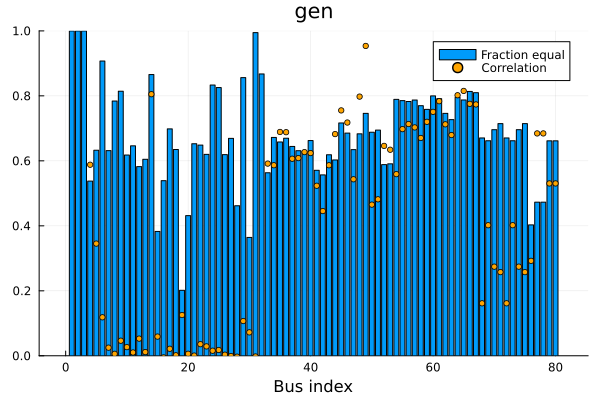

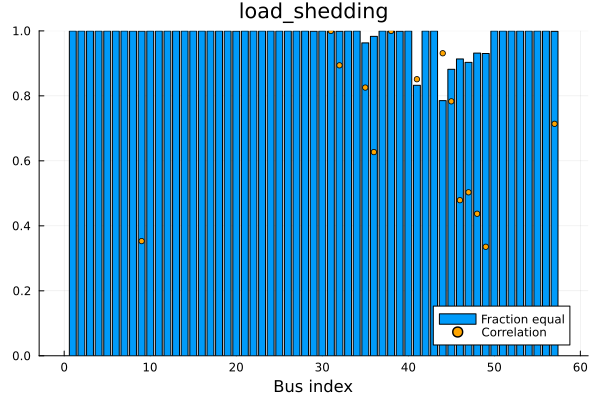

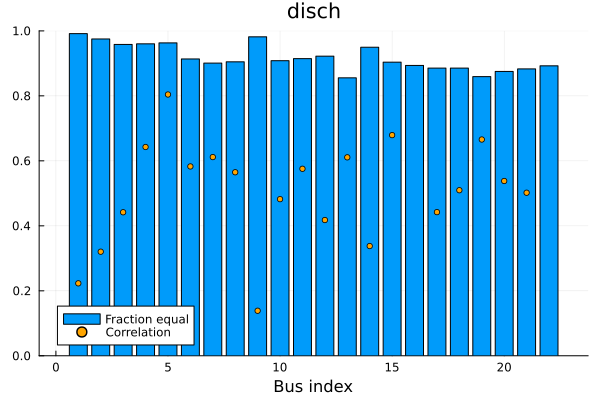

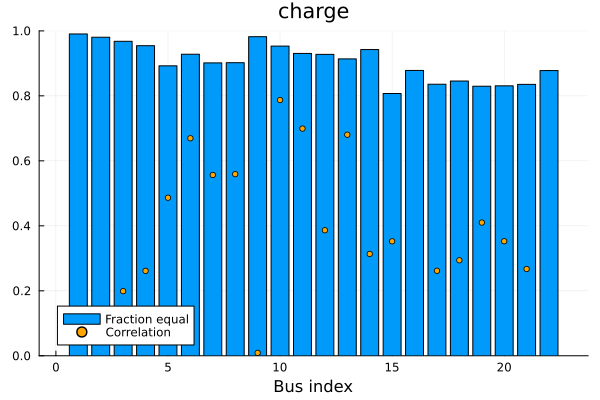

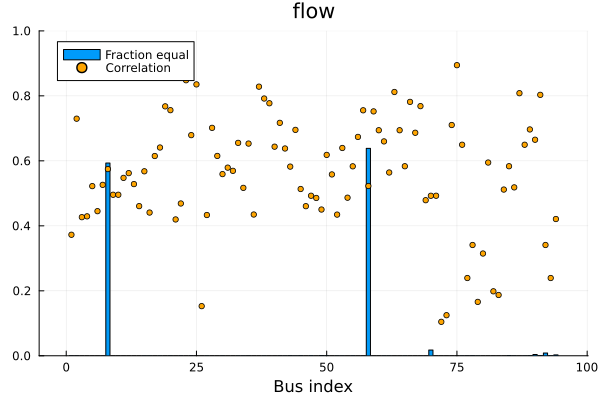

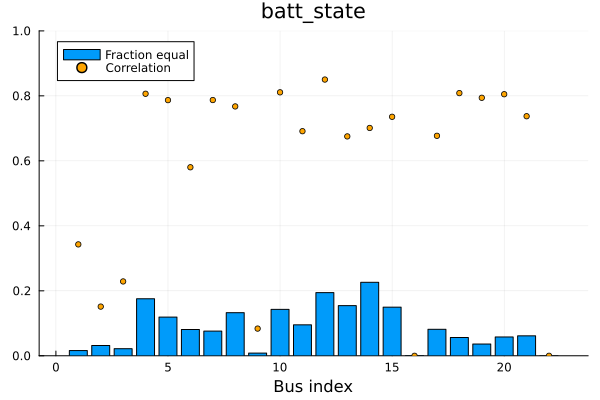

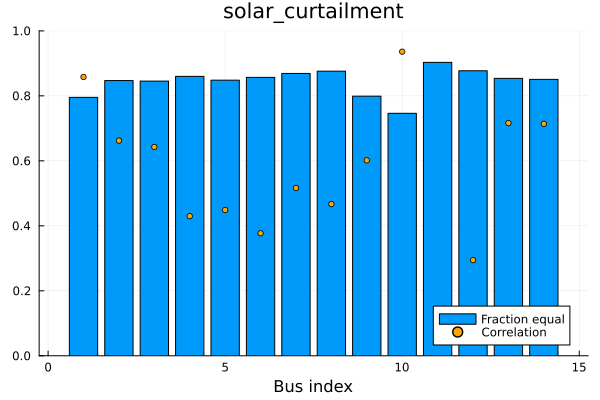

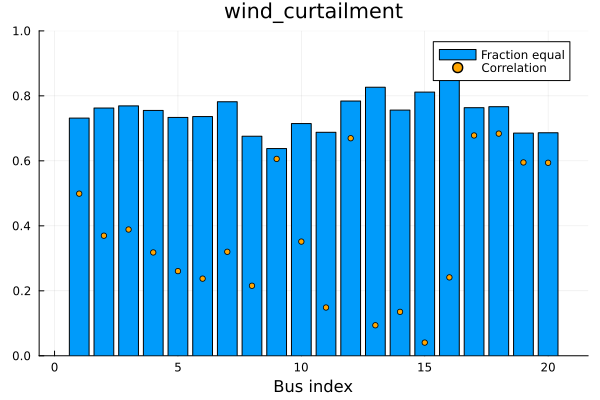

In [35]:
# Compare
orig_vars = Dict([("gen", "gen"), 
                ("batt_state", "battstate"), 
                ("disch", "disch"), 
                ("charge", "charege"), 
                ("flow", "flow"), 
                ("load_shedding", "loadshed"), 
                ("solar_curtailment","sc"), 
                ("wind_curtailment", "wc")])

# Loop through all
for (var_to_plot, orig_var_to_plot) in orig_vars
    # Plot
    df_julia = CSV.read("$(julia_path)/$(var_to_plot)_$(year).csv", DataFrame, header=false);
    df_orig = CSV.read("$(orig_path)/$(orig_var_to_plot)_$(year).csv", DataFrame, header=false);

    # Calculate percentage equal across all rows (to 2 DPs)
    pct_equal = mean(round.(Matrix(df_julia), digits=2) .== round.(Matrix(df_orig), digits=2), dims=2)

    # Calculate correlation
    correlation = [cor(Vector(df_julia[i, :]), Vector(df_orig[i, :])) for i in 1:size(df_julia, 1)]

    # Plot heatmap
    p = bar(pct_equal, xlabel="Bus index", ylabel="", title=var_to_plot, label="Fraction equal", ylimits=(0,1.))
    scatter!(1:length(correlation), correlation, color=:orange, markersize=3, label="Correlation")
    display(p)
end

In [97]:
# df = CSV.read("data/grid/npcc_new.csv", DataFrame);

# plot(df.xcoord, df.ycoord, 
#     zcolor = df.busIdx,
#     seriestype = :scatter,
#     markersize=5,
#     color = palette(:heat, size(df)[1]))